# **COVID-19 Impact on Global Civilian Air Traffic**

Asaf Fried - 314078676 

Chen Dahan - 204606651


Data sources:

1.   https://opensky-network.org
2.   https://opendata.ecdc.europa.eu
3.   https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat





## 0. Project Setup

### 0.1 Install

In [ ]:
!pip install pycountry-convert
!pip install networkx

     |████████████████████████████████| 10.1MB 10.0MB/s 
     |████████████████████████████████| 235kB 45.6MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=a1291072e7313f02662457bd3fbc81e543096c41f2376c77b8031a75669fad9f
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 5.2 which is incompatible.
ERROR: pytest-cov 2.10.0 has requirement pytest>=4.6, but you'll have pytest 3.6.4 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1


### 0.2 Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import itertools
import warnings
import networkx as nx
import pycountry_convert as pyc
import plotly.express as px
import math
import plotly.graph_objects as go
from datetime import datetime


warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 0.3 Auxiliary Functions

In [ ]:
def flights_trend_plot(df_trend, mapping, max_display=None):
  """
  dispaly time series plot of flight count
  :param df_trend: DataFrame with filght callsign as columns and daily count as rows
  :param mapping: map of plot legend (e.g. cotninent, airline, etc.) to list of flight callsigns
  :max_display: limit amount of unique callsign plots in figure
  """
  for i, continent in enumerate(mapping.keys()):
    max_ = len(mapping[continent]) if max_display is None else min(max_display, len(mapping[continent])) 
    df = df_trend[mapping[continent][:max_]]  
    df['day'] = df.index.values
    fig = px.line(pd.melt(df, ['day'], var_name="airport"), x='day', y='value', color='airport')
    fig.update_layout(
      title=continent,
      yaxis_title="# of flight from origin",
    )


    fig.show()

In [ ]:
def create_flight_route_graphs(df_start, df_end, dict_airports):
  """
  creates graph with flite routes from 'US' (central node) to other airports (domestic / international)
  :param df_start: DataFrame with filtered flight from start date (1st snapshot)
  :param df_end: DataFrame with filtered flight from end date (2nd snapshot)
  :param dict_airports: mapping from airport identification code to country name 
  :return: 
      - start domestic flight graph
      - end domestic flight graph
      - start international flight graph
      - end international flight graph
  """
  g_start_domestic = nx.Graph()
  g_start_international = nx.Graph()
  g_end_domestic = nx.Graph()
  g_end_international = nx.Graph()

  for i, row in df_end.iterrows():
    if dict_airports.get(row["origin"]) == 'US':
      if dict_airports.get(row["destination"]) != "US":
        g_end_international.add_edge('US', row["destination"])
      else:
        g_end_domestic.add_edge('US', row["destination"])

  for i, row in df_start.iterrows():
    if dict_airports.get(row["origin"]) == 'US':
      if dict_airports.get(row["destination"]) != "US":
        g_start_international.add_edge('US', row["destination"])
      else:
        g_start_domestic.add_edge('US', row["destination"])

  return g_start_domestic, g_end_domestic, g_start_international, g_end_international

In [ ]:
def flight_route_snapshot_plot(g_start_domestic, g_end_domestic, g_start_international, g_end_international):
  """
  plots flight route snapshot graphs
  :param g_start_domestic: start domestic flight graph
  :param g_end_domestic: end domestic flight graph
  :param g_start_international: start international flight graph
  :param g_end_international: end international flight graph
  """
  fix , axes = plt.subplots(2, 2, figsize=(20, 20))

  axes[0][0].set_title(f'US Domestic Flights - 2020-01-10\n Number of nodes: {len(g_start_domestic.nodes)} \n Number of edges: {len(g_start_domestic.edges)}')
  axes[0][1].set_title(f'US International Flights - 2020-01-10\n Number of nodes: {len(g_start_international.nodes)} \n Number of edges: {len(g_start_international.edges)}')
  axes[1][0].set_title(f'US Domestic Flights - 2020-04-10\n Number of nodes: {len(g_end_domestic.nodes)} \n Number of edges: {len(g_end_domestic.edges)}')
  axes[1][1].set_title(f'US International Flights - 2020-04-10\n Number of nodes: {len(g_end_international.nodes)} \n Number of edges: {len(g_end_international.edges)}')


  nx.draw_kamada_kawai(g_start_domestic, with_labels=True, ax=axes[0][0])
  nx.draw_kamada_kawai(g_start_international, with_labels=True, ax=axes[0][1])
  nx.draw_kamada_kawai(g_end_domestic, with_labels=True, ax=axes[1][0])
  nx.draw_kamada_kawai(g_end_international, with_labels=True, ax=axes[1][1])

In [ ]:
def map_view_flight_snapshot_plot(locations, title):
  """
  plots flight route form 'US' snapshot map view
  :param locations: list of countires representing a flight route destination (US is source)
  :param title: the title text
  """
  fig = go.Figure()


  flight_paths = []
  for i in range(len(locations)):
    fig.add_trace(
        go.Scattergeo(
            locationmode = 'country names',
            locations = [locations[i], 'USA'],
            mode = 'lines',
            line = dict(width = 1,color = 'red'),
        )
    )

  fig.update_layout(
      title_text = title,
      showlegend = False,
      geo = dict(
          scope = 'world',
          projection_type = 'equirectangular',
          showland = True,
          landcolor = 'rgb(243, 243, 243)',
          countrycolor = 'rgb(204, 204, 204)',
      ),
  )

  fig.show()

In [ ]:
#bat plot for  'cases'+'deaths'
def covid_bar_plot(_df_covid):
  _df_covid_gb=_df_covid.groupby(['continentExp','month','year'],as_index=False).sum()
  for i in ['cases','deaths']:
    fig = px.bar(_df_covid_gb, x='month', y=i,color='continentExp')
    fig.update_layout(barmode='group',title='#'+i+' by continent')
    fig.show()

#scatter_geo plot for 'cases'+'deaths'
def covid_scatter_geo_plot(_df_covid):
  for i in ['cases','deaths']:
    _df_covid_scatter=covid_group_by_continent(datetime(2020, 1, 1).timestamp(),datetime(2020, 8, 1).timestamp(),_df_covid,i)

    #plot scatter_geo animation
    fig = px.scatter_geo(
        _df_covid_scatter, 
        locations='countryterritoryCode',
        color='continentExp',
        hover_name='countriesAndTerritories',
        size=i,
        projection="natural earth",
        animation_frame="date",
        title=f'World COVID-19 '+i
    )
    fig.show()



"""
filter dataframe _df_covid acorrding to begin and end params
column_to_count is the column choosen for the sum and cusum
"""
def covid_group_by_continent(begin,end,_df_covid,column_to_count):
  #filter by dates
  _df_covid_2=_df_covid[_df_covid['dateRep'].apply(lambda x: (x.timestamp() > begin) and (x.timestamp() < end))]
  _df_covid_2=_df_covid_2[_df_covid_2[column_to_count]>=0] #remove outliers 
  #sum column_to_count for each country by day 
  _df_covid_2=_df_covid_2.groupby(['countryterritoryCode','continentExp','countriesAndTerritories','month','day'],as_index=False)[column_to_count].sum()
  #sort by date
  _df_covid_2=_df_covid_2.sort_values(['month','day'])
  #cumulative sum using cumsum 
  _df_covid_2[column_to_count]=_df_covid_2.groupby(['countryterritoryCode','continentExp','countriesAndTerritories'])[column_to_count].cumsum()
  #change dateRep for plotting
  _df_covid_2['date']=_df_covid_2.apply(lambda row: str(row['day'])+'/'+str(row['month']),axis=1)
  return _df_covid_2

"""
create country name to continent code dict
"""
def country_to_continent_code_dict():
  #create country to continent code dict
  country_code_to_continent_code_dict={i:pyc.convert_continent_code_to_continent_name(pyc.country_alpha2_to_continent_code(i)) if i!= None else None for i in df_flights['origin_country_code'].unique()}
  country_code_to_continent_code_dict2={i:pyc.convert_continent_code_to_continent_name(pyc.country_alpha2_to_continent_code(i)) if i!= None else None for i in df_flights['destination_country_code'].unique()}
  country_code_to_continent_code_dict = {**country_code_to_continent_code_dict, **country_code_to_continent_code_dict2}
  #change South/North America to America in order to match covid dataset
  for i in country_code_to_continent_code_dict.keys():
    if(country_code_to_continent_code_dict[i]=="South America" or country_code_to_continent_code_dict[i]=="North America" ):
      country_code_to_continent_code_dict[i]='America'
  return country_code_to_continent_code_dict

"""
pre-process before creating scatter_geo
pre-process flights dataframe 
and pre-process df_covid dates
"""
def preprocess_flights(df_flights,df_covid):
  # dest+orig airport name to alpha2 country code
  df_flights['destination_country_code']=df_flights['destination'].apply(lambda x: dict_airports[x] if (x in dict_airports) else None)
  df_flights['origin_country_code']=df_flights['origin'].apply(lambda x: dict_airports[x] if (x in dict_airports) else None)
  #count num of flights from x to y on the same day
  df_flights_temp=pd.DataFrame({'count' : df_flights.groupby( ['day','destination_country_code','origin_country_code']).size()}).reset_index()
  #add continent name for origin and dest
  country_code_to_continent_code_dict=country_to_continent_code_dict()
  df_flights_temp['destination_continent']=[country_code_to_continent_code_dict[i] if i else None for i in df_flights_temp['destination_country_code'] ]
  df_flights_temp['origin_continent']=[country_code_to_continent_code_dict[i] if i else None for i in df_flights_temp['origin_country_code'] ]
  #df_flights_- filter the countries which we don't have covid information about
  x=df_covid['geoId'].unique()
  df_flights_=df_flights_temp[(df_flights_temp['destination_country_code'].isin(x)) & (df_flights_temp['origin_country_code'].isin(x))] 
  df_covid['dateRep'] = pd.to_datetime(df_covid['dateRep'], utc = True)
  #change dest+orig country in flights from alpha2 to alpha3
  df_flights_['destination_country_code']=df_flights_['destination_country_code'].apply(lambda x: pyc.map_country_alpha2_to_country_alpha3()[x])
  df_flights_['origin_country_code']=df_flights_['origin_country_code'].apply(lambda x: pyc.map_country_alpha2_to_country_alpha3()[x])
  return df_flights_


In [ ]:
"""
print flights and covid cases scatter_geo for each month
months: from - to 
"""
def scatter_geo_covid_flights_by_month(df_flights_,_from,_to):
  cont=df_flights_['destination_continent'].unique()
  clr=['#19D3F3', '#FF6692', '#B6E880', '#AB63FA', '#FFA15A', '#FF97FF', '#FECB52']
  map_clr_cnt=dict(zip(cont,clr))
  map_month_name=dict(zip((2,3,4,5,6),('February','March','April','May','Jun')))

  for i in range(_from,_to):
    t1= datetime(2020, i+1, 1).timestamp()
    t2= datetime(2020, i, 1).timestamp()
    flights_filterd_by_date=df_flights_[df_flights_['day'].apply(lambda x: (x.timestamp() < t1) and (x.timestamp() >= t2))]
    #filter flights where dest == orig 
    flights_filterd_by_date=flights_filterd_by_date[flights_filterd_by_date['destination_continent'] != flights_filterd_by_date['origin_continent']]
    #sum flights count for the whole month
    flights_filterd_by_date=flights_filterd_by_date.groupby(['destination_country_code','origin_country_code','destination_continent','origin_continent'],as_index=False)['count'].sum()
    flights_filterd_by_date=flights_filterd_by_date[flights_filterd_by_date['count']>15] #drop under 20 flights - nothing interesting to look at 
    #filter dates and sum covid cases for the whole month for each geoid
    covid_filterd_by_date=df_covid[df_covid['dateRep'].apply(lambda x: (x.timestamp() < t1) and (x.timestamp() >= t2))]
    covid_filterd_by_date=covid_filterd_by_date[covid_filterd_by_date['cases']>=0]
    covid_filterd_by_date=covid_filterd_by_date.groupby(['countryterritoryCode','continentExp'],as_index=False)['cases'].sum()
    covid_filterd_by_date['clr']=covid_filterd_by_date['continentExp'].apply(lambda x: map_clr_cnt[x])
    fig = px.scatter_geo(
      covid_filterd_by_date, 
      locationmode = 'ISO-3',
      locations='countryterritoryCode',
      color= 'clr',
      hover_name='countryterritoryCode',
      size='cases',
      projection="natural earth",
      #animation_frame="month",
      title=f'World COVID-19 Case : ' +map_month_name[i]
    )
    for j,row in flights_filterd_by_date.iterrows():
      fig.add_trace(
          go.Scattergeo(
              locationmode = 'ISO-3',
              locations = [row['destination_country_code'], row['origin_country_code']],
              mode = 'lines',
              line = dict(width = math.log10(row['count']),color =map_clr_cnt[row['origin_continent']]),
          )
      )
    fig.update(layout_showlegend=False)
    fig.show()


In [ ]:
def flights_covid_corr(df_flights_,df_covid):
  df_flights_=df_flights_.rename({'day':'dateRep','count':'flights_count'},axis='columns')
  df_flights_['month']=df_flights_['dateRep'].apply(lambda x: x.month)
  df_flights_['day']=df_flights_['dateRep'].apply(lambda x: x.day)
  #merge flights and covid-19 DataFrames info
  merge=pd.merge(df_flights_,df_covid, left_on=['day','month','destination_country_code'], right_on=['day','month','countryterritoryCode'])
  merge=merge[['origin_country_code','destination_country_code','flights_count','countriesAndTerritories','destination_continent','origin_continent','month','day','cases','deaths','dateRep_x']]
  #look for correlation - per country
  corr_map=pd.DataFrame(columns=['country_code','country','corr'])
  country_corr=merge.groupby(['month','day','destination_country_code'],as_index=False).agg({"flights_count": "sum",'cases':'sum'})
  for i in country_corr['destination_country_code'].unique():
    temp=country_corr[country_corr['destination_country_code']==i]
    temp=temp.sort_values(['month', 'day'])
    if(len(temp)>10): #at least 10 days info 
      corr=temp['flights_count'].corr(temp['cases'])
      if(not math.isnan(corr)):
        corr_map=corr_map.append({'country_code': i,'country':pyc.map_country_alpha3_to_country_name()[i],'corr':corr}, ignore_index=True)
  return corr_map

## 1. Download Data

In [ ]:
!mkdir ./datasets

### 1.1 COVID-19



In [ ]:
!mkdir ./datasets/covid
!wget -O ./datasets/covid/data.csv https://opendata.ecdc.europa.eu/covid19/casedistribution/csv

--2020-07-21 12:17:03--  https://opendata.ecdc.europa.eu/covid19/casedistribution/csv
Resolving opendata.ecdc.europa.eu (opendata.ecdc.europa.eu)... 212.181.0.63
Connecting to opendata.ecdc.europa.eu (opendata.ecdc.europa.eu)|212.181.0.63|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/ [following]
--2020-07-21 12:17:04--  https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/
Reusing existing connection to opendata.ecdc.europa.eu:443.
HTTP request sent, awaiting response... 200 OK
Length: 2115502 (2.0M) [application/octet-stream]
Saving to: ‘./datasets/covid/data.csv’

./datasets/covid/da 100%[===================>]   2.02M   528KB/s    in 3.9s    

2020-07-21 12:17:08 (528 KB/s) - ‘./datasets/covid/data.csv’ saved [2115502/2115502]



### 1.2 Opensky

In [ ]:
!mkdir ./datasets/opensky

In [ ]:
!wget -O ./datasets/opensky/1.csv.gz https://opensky-network.org/datasets/covid-19/flightlist_20200101_20200131.csv.gz
!wget -O ./datasets/opensky/2.csv.gz https://opensky-network.org/datasets/covid-19/flightlist_20200201_20200229.csv.gz
!wget -O ./datasets/opensky/3.csv.gz https://opensky-network.org/datasets/covid-19/flightlist_20200301_20200331.csv.gz
!wget -O ./datasets/opensky/4.csv.gz https://opensky-network.org/datasets/covid-19/flightlist_20200401_20200430.csv.gz
!wget -O ./datasets/opensky/5.csv.gz https://opensky-network.org/datasets/covid-19/flightlist_20200501_20200531.csv.gz


!gunzip ./datasets/opensky/1.csv.gz 
!gunzip ./datasets/opensky/2.csv.gz 
!gunzip ./datasets/opensky/3.csv.gz
!gunzip ./datasets/opensky/4.csv.gz
!gunzip ./datasets/opensky/5.csv.gz

!rm -rf ./datasets/opensky/*.csv.gz

--2020-07-21 12:20:47--  https://opensky-network.org/datasets/covid-19/flightlist_20200101_20200131.csv.gz
Resolving opensky-network.org (opensky-network.org)... 194.209.200.2
Connecting to opensky-network.org (opensky-network.org)|194.209.200.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40427068 (39M) [application/x-gzip]
Saving to: ‘./datasets/opensky/1.csv.gz’

./datasets/opensky/ 100%[===================>]  38.55M  1.09MB/s    in 41s     

2020-07-21 12:21:28 (975 KB/s) - ‘./datasets/opensky/1.csv.gz’ saved [40427068/40427068]

--2020-07-21 12:21:29--  https://opensky-network.org/datasets/covid-19/flightlist_20200201_20200229.csv.gz
Resolving opensky-network.org (opensky-network.org)... 194.209.200.2
Connecting to opensky-network.org (opensky-network.org)|194.209.200.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38058096 (36M) [application/x-gzip]
Saving to: ‘./datasets/opensky/2.csv.gz’

./datasets/opensky/ 100%[========

### 1.3 Airports

In [ ]:
!mkdir ./datasets/airports

In [ ]:
!wget -O ./datasets/airports/airports.csv http://ourairports.com/data/airports.csv

In [ ]:
!wget -O ./datasets/airports/airports.dat https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat

## 2. Read Data



### 2.1 COVID-19

In [ ]:
#TODO- mismatch between daterep to day+month in some cases(day+month is the updated)
#TODO 2- part of the cases values are negative- why?
df_covid = pd.read_csv("./datasets/covid/data.csv", parse_dates=['dateRep'])
df_covid.shape

(30967, 12)

In [ ]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30967 entries, 0 to 30966
Data columns (total 12 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   dateRep                                                     30967 non-null  datetime64[ns]
 1   day                                                         30967 non-null  int64         
 2   month                                                       30967 non-null  int64         
 3   year                                                        30967 non-null  int64         
 4   cases                                                       30967 non-null  int64         
 5   deaths                                                      30967 non-null  int64         
 6   countriesAndTerritories                                     30967 non-null  object        
 7   geoId                 

In [ ]:
df_covid.head()

dateRep  ...  Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0 2020-07-20  ...                                           6.634814         
1 2020-07-19  ...                                           6.910827         
2 2020-07-18  ...                                           7.794067         
3 2020-07-17  ...                                           8.012248         
4 2020-07-16  ...                                           8.301404         

[5 rows x 12 columns]

### 2.2 Opensky

In [ ]:
df_flights = pd.concat(
    pd.read_csv(file, parse_dates=["firstseen", "lastseen", "day"])
    for file in pathlib.Path("./datasets/opensky").glob("*.csv")
)

df_flights.shape

(4668408, 11)

In [ ]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4668408 entries, 0 to 1519102
Data columns (total 11 columns):
 #   Column        Dtype              
---  ------        -----              
 0   Unnamed: 0    float64            
 1   callsign      object             
 2   number        object             
 3   icao24        object             
 4   registration  object             
 5   typecode      object             
 6   origin        object             
 7   destination   object             
 8   firstseen     datetime64[ns, UTC]
 9   lastseen      datetime64[ns, UTC]
 10  day           datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](3), float64(1), object(7)
memory usage: 427.4+ MB


In [ ]:
df_flights.head()

Unnamed: 0 callsign  ...                  lastseen                       day
0         0.0  AUA1028  ... 2020-04-01 00:41:43+00:00 2020-04-01 00:00:00+00:00
1         1.0   CSN472  ... 2020-04-01 07:09:16+00:00 2020-04-01 00:00:00+00:00
2         2.0   CSN461  ... 2020-04-01 12:02:53+00:00 2020-04-01 00:00:00+00:00
3         3.0    UPS32  ... 2020-04-01 04:34:55+00:00 2020-04-01 00:00:00+00:00
4         4.0   ANA179  ... 2020-04-01 05:05:28+00:00 2020-04-01 00:00:00+00:00

[5 rows x 11 columns]

### 2.3 Airports

In [ ]:
df_airports_code = pd.read_csv("./datasets/airports/airports.csv")
df_airports_code=df_airports_code[['ident','iso_country']]
dict_airports=dict(df_airports_code.to_dict('split')['data']) #create airport code to country dict 

In [ ]:
df_airports_dat = pd.read_csv("./datasets/airports/airports.dat", 
                              names=["name", "city", "country", "iata", "icao", "lat", "lon", "altitude", "timezone", "DST", "Tz timezone", "type" ,"source"])

## 3. Air Traffic Analysis by Region

### 3.1 Total Continent Departures Trend

In this section we will analyze the total amount of flight departures from each continent, during the months of January - May.

For each continent several major airports were plotted to receive an indication of the overall continent trend.

In [ ]:
airports = {
    "Europe": ["LFPG", "EGLL", "EHAM", "EDDF", "LEMD", "LIRF", "LSZH", "UUEE"],
    "Asia": ["VHHH", "RJBB", "RJTT", "RKSI", "RCTP", "RPLL", "YSSY", "YMML", "OMDB", "VABB", "VIDP", "WSSS"],
    "America": ["CYYZ", "KSFO", "KLAX", "KATL", "KJFK", "SBGR"],
    "Africa": ["FAOR", "DAAG", "GMMN"],
    "Oceania" : ["YSCB", "YWLM", "YBCS", "YBCG", "YPAD", "YMHB", "YMAV", "YMML", "YPPH"]
}

In [ ]:
df_airport = pd.concat(
    (
        df_flights.query(f'origin == "{airport}"')
        .groupby("day")
        .agg({"icao24": "count"})
        .rename(columns={"icao24": airport})
        for airport in list(itertools.chain(*airports.values()))
    ),
    axis=1,
)

In [ ]:
df_airport.head()

LFPG  EGLL  EHAM  EDDF  ...  YMHB  YMAV  YMML  YPPH
day                                                ...                        
2020-01-01 00:00:00+00:00   466   467   431   371  ...  25.0   8.0   267  93.0
2020-01-02 00:00:00+00:00   460   478   441   490  ...  21.0   8.0   278  83.0
2020-01-03 00:00:00+00:00   485   412   456   485  ...  17.0   7.0   233  77.0
2020-01-04 00:00:00+00:00   505   474   416   511  ...  16.0   9.0   229  69.0
2020-01-05 00:00:00+00:00   531   510   484   540  ...  18.0   9.0   270  94.0

[5 rows x 39 columns]

In [ ]:
flights_trend_plot(df_airport, airports, max_display=6)

### 3.2 Network Flight Route Snapshot US

In this section we will plot the a snapshot of US flight routes as a network on the 10th of Jan and on the 10th of April.

In each network the central node will represent US airports in general and the remaining nodes will present airports (either domestic or international).

An edge will present a flight that departed from a US airport to another airport (either domestic or international).

In [ ]:
df_start = df_flights.query("day == '2020-01-10 00:00:00+00:00'").dropna(subset=['origin', 'destination'])
df_end = df_flights.query("day == '2020-04-10 00:00:00+00:00'").dropna(subset=['origin', 'destination'])

In [ ]:
df_start

callsign  number  ... Unnamed: 0 callsign_short
403772   CSH869   FM869  ...        NaN            CSH
404145    QFA64    QF64  ...        NaN            QFA
404164   CES201     NaN  ...        NaN            CES
404387   CES219     NaN  ...        NaN            CES
405759   CXA805     NaN  ...        NaN            CXA
...         ...     ...  ...        ...            ...
504102  AXM6046  AK6046  ...        NaN            AXM
504236  PDT4766     NaN  ...        NaN            PDT
504287  QXE2081  QX2081  ...        NaN            QXE
504313  JIA5615     NaN  ...        NaN            JIA
504378   UAE701   EK701  ...        NaN            UAE

[31101 rows x 12 columns]

In [ ]:
g_start_domestic, g_end_domestic, g_start_international, g_end_international = create_flight_route_graphs(df_start, df_end, dict_airports)

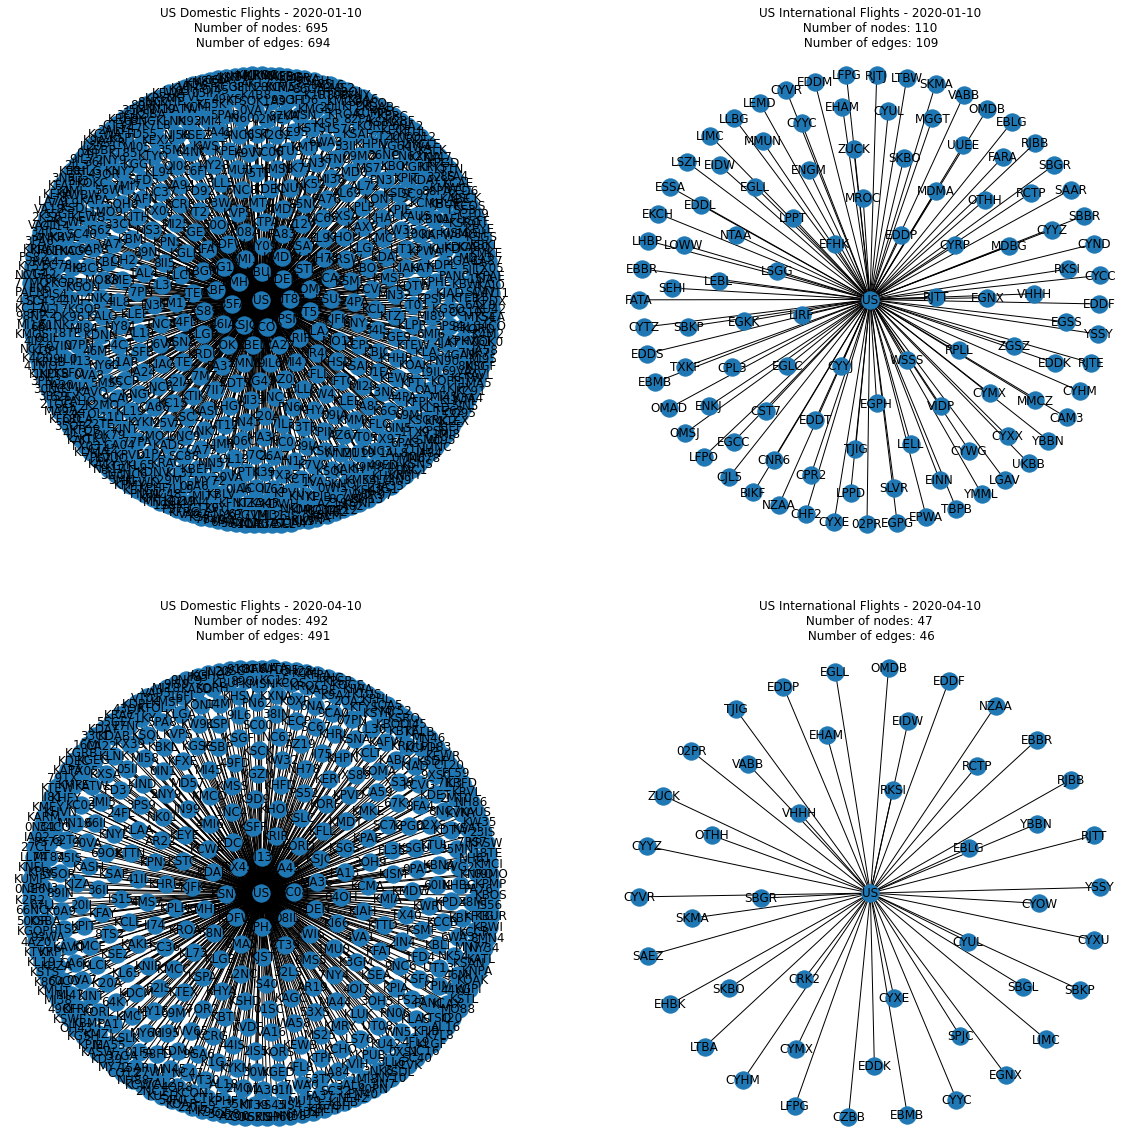

In [ ]:
flight_route_snapshot_plot(g_start_domestic, g_end_domestic, g_start_international, g_end_international)

In [ ]:
print(f'Domestic drop in flight routes: {round(1 - len(g_end_domestic.edges) / len(g_start_domestic.edges), 2)} %')

Domestic drop in flight routes: 0.29 %


In [ ]:
print(f'International drop in flight routes: {round(1 - len(g_end_international.edges) / len(g_start_international.edges), 2)} %')

International drop in flight routes: 0.58 %


### 3.3 Map View International Flight Route Snapshot US

In [ ]:
airport_icao_start = list(g_start_international.nodes())
airport_icao_end = list(g_end_international.nodes())

In [ ]:
locations_start = [list(df_airports_dat[df_airports_dat['icao'] == x]["country"].values) for x in airport_icao_start]
locations_start = list(itertools.chain.from_iterable(locations_start))

In [ ]:
locations_end = [list(df_airports_dat[df_airports_dat['icao'] == x]["country"].values) for x in airport_icao_end]
locations_end = list(itertools.chain.from_iterable(locations_end))

In [ ]:
map_view_flight_snapshot_plot(locations_start, title="Janurary 2020 USA international departing flight paths")

In [ ]:
map_view_flight_snapshot_plot(locations_end, title="April 2020 USA international departing flight paths")

### 3.4 Conclusions

From this chapter we can observe the following:
 - section 3.1: All continents have decreased their air traffic by a significant amount during the months of Jan - May
 - section 3.1: Europe, America, Oceania and Africa have all experienced a sharp decline in air traffic during mid March
 - section 3.1: Unlike the other regions, Asia air traffic has started declining from mid Jan and was much more gradual 
 - section 3.2 + 3.3: US has mainly decreased its international flight routes during the pandemic (domestic flight routes were less impacted) - which explains why in section 3.1 we can still see hundreds of daily flight departures in America (in comparison to Europe, where air traffic has almost completely stopped)


## 4. Air Traffic Analysis by Airline

### 4.1 Total Flights Trend

In this section we will analyze the total amount of flights by airline type (commercial, low cost and cargo), during the months of January - May.

For each airline type, several main airlines were plotted to receive an indication of the overall trend.

In [ ]:
airlines = {
    "Commerical airlines": ["AFR", "KLM", "BAW", "DLH", "AZA", "SWR", "AAL", "ACA", "DAL", "UAL"],
    "Commerical low-cost airlines": ["EZY", "VLG", "TRA", "RYR", "ROU", "AXM", "WZZ", "APJ", "JST"],
    "Cargo airlines": ["FDX", "UPS", "GTI", "CLX", "GEC"]
}

In [ ]:
df_flights["callsign_short"] = [x[:3] for x in df_flights["callsign"]]

In [ ]:
df_airlines = pd.concat(
    (
        df_flights.query(f'callsign_short == "{airline}"')
        .groupby("day")
        .agg({"callsign_short": "count"})
        .rename(columns={"callsign_short": airline})
        for airline in list(itertools.chain(*airlines.values()))
    ),
    axis=1,
)

In [ ]:
df_airlines.head()

AFR  KLM  BAW   DLH  AZA  ...  FDX  UPS  GTI  CLX  GEC
day                                                  ...                         
2020-01-01 00:00:00+00:00  629  451  545   594  339  ...  318  219   24    6   10
2020-01-02 00:00:00+00:00  646  460  591   986  344  ...  387  282   33    8    6
2020-01-03 00:00:00+00:00  718  484  603  1052  361  ...  758  552   74   11   10
2020-01-04 00:00:00+00:00  674  435  593  1026  292  ...  511  263   84   14   12
2020-01-05 00:00:00+00:00  725  473  636  1068  321  ...  225  125   76   10   13

[5 rows x 24 columns]

In [ ]:
flights_trend_plot(df_airlines, airlines)

### 4.2 Conclusions

From this chapter we can observe the following:
 - All commercial airlines have decreased their flights by a significant amount during the months of Jan - May
 - The major commercial airlines (non low cost) which are backed by governments (AAL, DAL, etc.) were still operating with high traffic during the pandemic
 - Low cost commercial airlines seem to have been impacted more, since all operations have dropped to nearly zero
 - Cargo flights had no impact during Jan - May, and flight trends seem to be the same


## 5. COVID-19 cases Analysis

### 5.1 COVID-19 by Continent

In this section we will analyze the total amount of covid cases/deaths by continent during the months of January - July.

In [ ]:
_df_covid= df_covid[df_covid['month'] != 12] # clean data
covid_bar_plot(_df_covid)

Coronavirus COVID-19 global cases and deaths animation map 

In [ ]:
covid_scatter_geo_plot(_df_covid)

### 5.2 Conclusions

From this paragraph we can observe the following:

*   The covid-19 pandemic began in Asia.
*   The most affected continents are Europe, America and Asia.
*   The most affected country in America is United States.
*   America and Europe experienced a sharp increase during April  








## 6. COVID-19 + Airline cases Analysis

In this section we will analyze the relation between covid-19 cases to flights. 

### 6.1 Relation Visualization

In [ ]:
df_flights_ = preprocess_flights(df_flights,df_covid)
scatter_geo_covid_flights_by_month(df_flights_,2,6)

### 6.2 Correlation Between COVID-19 Cases And Flights

correlation mean values is: 

In [ ]:
corr_map= flights_covid_corr(df_flights_,df_covid)
corr_map['corr'].mean()

-0.30161286168213025

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9158507940>]],
      dtype=object)

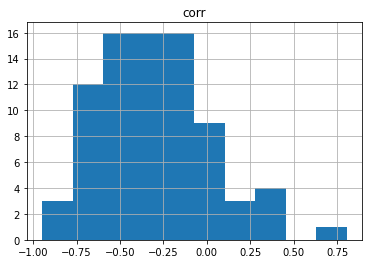

In [ ]:
corr_map.hist('corr')

In [ ]:
fig =  px.scatter_geo(
    corr_map, 
    locations='country_code',
    color='corr',
    hover_name='country',
    projection="natural earth",
    title=f'COVID-19 and flights correlation'
)
fig.show()

### 6.3 Conclusions

* It is probably safe to say that flights have contributed to spreading the virus all over the world. A classic example is the USA which is one of the countries with the highest amount of incoming flights and also one of the biggest centers of the COVID-19 outbreak. 
* There is a connection between the Covid-19 cases to the number of flights. Detailed explanation in our report. 
